# Imports

In [20]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import pandas_ta as pta
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
    
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

container = None

if container is not None:
    print("Deleting container")
    free_mem(container)
    
gc.collect()

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

INFO:freqtrade.nbtools.backtest:Initialized DataLoader with 5 max datas.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lightning Module

In [2]:
MINI_DATA = False  # True if used for testing purposes

attr.s(repr=False)
class CatBoostModule(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 9, 1)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "15n30-catboost_l3",
            timeframe   = "15m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = datetime(2016, 1, 1),
            trainval_end    = now - timedelta(days=91),
            
            # Backtest Optimization datetime
            opt_start = now - timedelta(days=90),
            opt_end   = now - timedelta(days=46),
            
            # Unbiased Backtest datetime
            test_start = now - timedelta(days=45),
            test_end   = now,
            
            # Optional
            num_training_epochs = 15000,
            learning_rate = 0.007,
        )
        
        # Optional custom config attributes
        config.add_custom("num_future_candles", 2)
        config.add_custom("num_classification_classes", 5)
        config.add_custom("hardware", "GPU")
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        """ Where your data is stored
        """
        path_data_exchange = cwd.parent / "mount" / "data" / exchange
        maximum_data = 999 if not MINI_DATA else 5
        
        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE[:maximum_data]
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ On Add Features will be used in inference
        """
        # Start add features
        spaces = [4, 6, 12, 16, 26, 50, 100, 200]
        
        for i in spaces:
            # Basics
            df_onepair[f"ml_smadiff_{i}"] = (df_onepair['close'].rolling(i).mean() - df_onepair['close'])
            df_onepair[f"ml_maxdiff_{i}"] = (df_onepair['close'].rolling(i).max() - df_onepair['close'])
            df_onepair[f"ml_mindiff_{i}"] = (df_onepair['close'].rolling(i).min() - df_onepair['close'])
            df_onepair[f"ml_std_{i}"] = df_onepair['close'].rolling(i).std()
            df_onepair[f"ml_ma_{i}"] = df_onepair['close'].pct_change(i).rolling(i).mean()
            
            # Volume Basics
            df_onepair[f"ml_volmaxdiff_{i}"] = (df_onepair['volume'].rolling(i).max() - df_onepair['volume'])
            df_onepair[f"ml_volmindiff_{i}"] = (df_onepair['volume'].rolling(i).min() - df_onepair['volume'])
            df_onepair[f"ml_volsmadiff_{i}"] = (df_onepair['volume'].rolling(i).mean() - df_onepair['volume'])
            df_onepair[f"ml_volstd_{i}"] = df_onepair['volume'].rolling(i).std()
            df_onepair[f"ml_volma_{i}"] = df_onepair['volume'].pct_change(i).rolling(i).mean()
            
            # Technical Indicators
            df_onepair.ta.macd(fast=i/2, slow=i, signal=9, append=True)
            df_onepair.ta.rsi(length=i, append=True)
            df_onepair.ta.cmo(length=i, append=True)
            df_onepair.ta.stochrsi(length=i, append=True)
            df_onepair.ta.trix(length=i, append=True)


        for i in range(1, 20):
            df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
            
        df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
        df_onepair['ml_z_score_120'] = ((df_onepair["ml_ma_15"] - df_onepair["ml_ma_15"].rolling(21).mean() + 1e-9) 
                             / (df_onepair["ml_ma_15"].rolling(21).std() + 1e-9))
        
        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Define the labels
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        """ Define the data to X_train, X_val, y_train, y_val
        """
        # val_split_date = pd.to_datetime(self.config.trainval_end - timedelta(days=60), utc=True, infer_datetime_format=True)
        
        # train = df_allpairs[df_allpairs["date"] < val_split_date]
        # val = df_allpairs[df_allpairs["date"] >= val_split_date]

        # print("Train start - end:", train["date"].min(), train["date"].max())
        # print("Val start - end:", val["date"].min(), val["date"].max())

        # X_train = train[self.config.columns_x]
        # X_val = val[self.config.columns_x]
        # y_train = train[self.config.column_y]
        # y_val = val[self.config.column_y]

        X = df_allpairs[self.config.columns_x]
        y = df_allpairs[self.config.column_y]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    
        print("Num train datas:", len(X_train))
        print("Num val datas:", len(X_val))

        return X_train, X_val, y_train, y_val
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        """ Define your model!
        """
        return CatBoostClassifier(
            custom_loss=[metrics.Accuracy()],
            iterations=self.config.num_training_epochs, 
            task_type=self.config.hardware,
            learning_rate=self.config.learning_rate,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        """ Training / model fit code
        """
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=1000,
        )
        print("Accuracy: %.4f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Inference, used in freqtrade
        """
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        df_preds = pd.DataFrame(preds)
        return df_preds
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoostModule()
container = LightningContainer(module)

# Dataset EDA Before Training

In [14]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(container)
X_train, X_val, y_train, y_val = container.final_processing(df_)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_.tail()

Load and preprocess data:   0%|          | 0/61 [00:00<?, ?it/s]

Num train datas: 2227079
Num val datas: 556770


,ml_smadiff_3,ml_maxdiff_3,ml_mindiff_3,ml_std_3,ml_ma_3,ml_volmaxdiff_3,ml_volmindiff_3,ml_volsmadiff_3,ml_volstd_3,ml_volma_3,...,ml_prevclose_13,ml_prevclose_14,ml_prevclose_15,ml_prevclose_16,ml_prevclose_17,ml_prevclose_18,ml_prevclose_19,ml_volume_pctchange,ml_z_score_120,ml_label
76106,0.001133,0.0073,-0.0039,0.005685,0.005341,49384.960938,0.000000,16585.171875,28406.054688,-0.528259,...,-0.033601,-0.030592,-0.040845,-0.043241,-0.044522,-0.043352,-0.046584,-0.427732,2.086976,2.0
76107,0.005833,0.0124,0.0000,0.006232,0.007997,30914.437500,-18470.523438,4147.971191,24952.412109,-0.228119,...,-0.024979,-0.030847,-0.027829,-0.038111,-0.040514,-0.041799,-0.040626,0.279548,1.871229,4.0
76108,-0.002033,0.0000,-0.0056,0.003099,0.001744,47792.000000,0.000000,25704.492188,24100.429688,-0.317056,...,-0.026405,-0.028021,-0.033870,-0.030862,-0.041112,-0.043507,-0.044789,-0.565296,1.753154,2.0
76109,-0.007667,0.0000,-0.0143,0.007206,0.000228,58788.562500,0.000000,23261.708984,31254.585938,-0.339828,...,-0.023007,-0.031101,-0.032709,-0.038530,-0.035536,-0.045737,-0.048121,-0.299215,1.633954,2.0
76110,0.003233,0.0092,0.0000,0.005173,0.001401,0.000000,-46398.242188,-27266.640625,24245.275391,-0.479484,...,-0.005628,-0.017998,-0.026134,-0.027750,-0.033601,-0.030592,-0.040845,1.801538,1.516932,0.0


In [15]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    
dataframe_statistics(df_)

N rows na: 0
N rows inf: 0
Cols na: []
Cols inf: []
Irregular (col, dtypes): []
Dataset Length: 2783849
Date Min: 2017-08-26 09:45:00+00:00
Date Max: 2021-04-30 23:30:00+00:00


<AxesSubplot:>

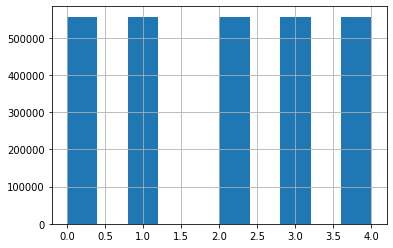

In [16]:
df_["ml_label"].hist()

In [17]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2783849 entries, 399 to 76110
Columns: 102 entries, ml_smadiff_3 to ml_label
dtypes: float32(102)
memory usage: 1.1 GB


In [18]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [3]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

freqtrade.ml.trainer - Validating model using mini training...


Load and preprocess data:   0%|          | 0/1 [00:00<?, ?it/s]

Num train datas: 96012
Num val datas: 24004
Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6083857	test: 1.6084079	best: 1.6084079 (0)	total: 17.5ms	remaining: 158ms
9:	learn: 1.5992705	test: 1.5995381	best: 1.5995381 (9)	total: 155ms	remaining: 0us
bestTest = 1.599538098
bestIteration = 9
Accuracy: 0.3164


C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe


PASSED: The model passed the validation test!
freqtrade.ml.trainer - Validate model OK!


Load and preprocess data:   0%|          | 0/61 [00:00<?, ?it/s]

Num train datas: 2516523
Num val datas: 629131


C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6089760	test: 1.6089295	best: 1.6089295 (0)	total: 57.8ms	remaining: 14m 26s
1000:	learn: 1.5326055	test: 1.5339902	best: 1.5339902 (1000)	total: 59.6s	remaining: 13m 54s
2000:	learn: 1.5273829	test: 1.5293489	best: 1.5293489 (2000)	total: 2m 16s	remaining: 14m 43s
3000:	learn: 1.5243594	test: 1.5269598	best: 1.5269598 (3000)	total: 3m 16s	remaining: 13m 3s
4000:	learn: 1.5220777	test: 1.5253207	best: 1.5253207 (4000)	total: 4m 18s	remaining: 11m 50s
5000:	learn: 1.5201438	test: 1.5240350	best: 1.5240350 (4999)	total: 5m 17s	remaining: 10m 35s
6000:	learn: 1.5184486	test: 1.5229892	best: 1.5229892 (6000)	total: 6m 20s	remaining: 9m 30s
7000:	learn: 1.5169215	test: 1.5220984	best: 1.5220984 (7000)	total: 7m 20s	remaining: 8m 23s
8000:	learn: 1.5155075	test: 1.5213254	best: 1.5213254 (8000)	total: 8m 25s	remaining: 7m 22s
9000:	learn: 1.5141864	test: 1.5206352	best: 1.5206352 (9000)	total: 9m 28s	remaining: 6m 18s
10000:	learn: 1.5129419	test: 1.5200188	best: 1.5200188 (10000

# Predictions EDA

In [11]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_val_preds = trainer.validate_predict(container)
df_val_preds

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']



Dataset: Binance BTC/USDT 15m iloc[-10000:] (Freqtrade Regularized)


DF WITH PREDICTIONS INFO
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 131026 to 141025
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    10000 non-null  datetime64[ns, UTC]
 1   open    10000 non-null  float64            
 2   high    10000 non-null  float64            
 3   low     10000 non-null  float64            
 4   close   10000 non-null  float64            
 5   volume  10000 non-null  float64            
 6   ml_0    9185 non-null   float64            
 7   ml_1    9185 non-null   float64            
 8   ml_2    9185 non-null   float64            
 9   ml_3    9185 non-null   float64            
 10  ml_4    9185 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(10)
memory usage: 937.5 KB
None


DF Original
----------
                            date      open  

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4
131026,2021-05-13 00:30:00+00:00,49711.83,50630.00,49578.94,49896.61,5110.913916,NaN,NaN,NaN,NaN,NaN
131027,2021-05-13 00:45:00+00:00,49896.15,50324.72,49581.44,49666.99,2389.969100,NaN,NaN,NaN,NaN,NaN
131028,2021-05-13 01:00:00+00:00,49661.12,50600.00,49305.43,50191.47,3869.211034,NaN,NaN,NaN,NaN,NaN
131029,2021-05-13 01:15:00+00:00,50191.47,50437.86,49972.44,50324.12,2755.398561,NaN,NaN,NaN,NaN,NaN
131030,2021-05-13 01:30:00+00:00,50314.99,50374.48,49665.94,49889.82,2116.566505,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
141021,2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,0.201529,0.255884,0.202371,0.166218,0.173998
141022,2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,0.186121,0.231312,0.211827,0.196422,0.174319
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.237812,0.162050,0.153346,0.197669,0.249123
141024,2021-08-25 04:00:00+00:00,47975.93,48245.00,47940.02,48155.56,275.930495,0.233152,0.200926,0.174560,0.174439,0.216924


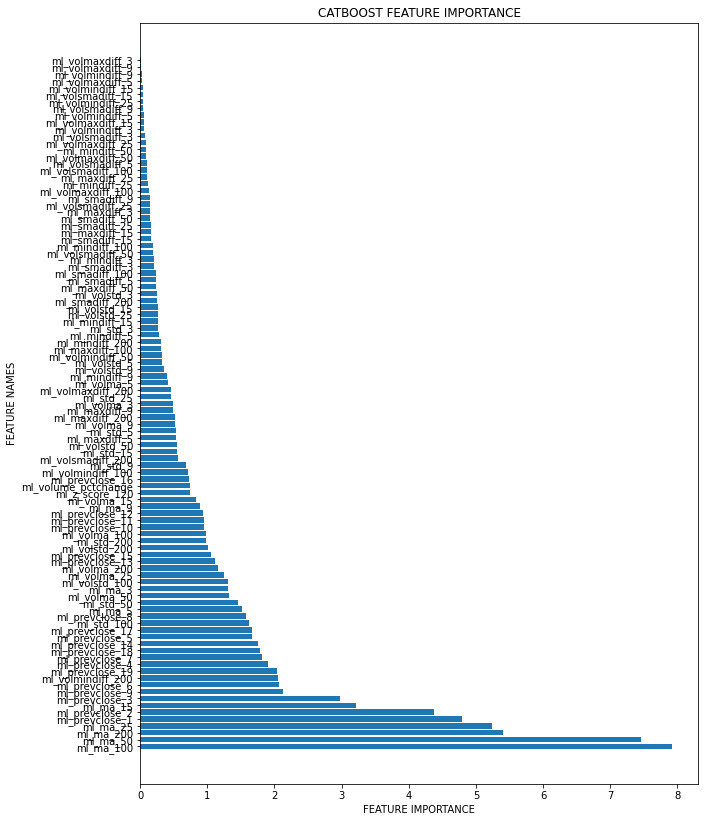

In [4]:
def plot_feature_importance(importance,names,model_type):
    import matplotlib.pyplot as plt
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(container.module.model.get_feature_importance(), container.config.columns_x, 'CATBOOST')

In [16]:
# TODO: Implement "container.get_sample_predictions()" that returns df in trainval data

df_val_preds["next"] = (df_val_preds["close"].shift(container.config.num_future_candles) / df_val_preds["close"]) - 1
df_val_preds["argmax_ml"] = df_val_preds[[f"ml_{x}"for x in range(5)]].idxmax(axis=1)
df_val_preds.loc[df_val_preds["argmax_ml"] == "ml_4"]

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4,next,argmax_ml
131425,2021-05-17 04:15:00+00:00,43147.31,43800.00,42700.93,43553.95,3136.411829,0.358041,0.073891,0.054471,0.072139,0.441457,-0.014660,ml_4
131426,2021-05-17 04:30:00+00:00,43553.83,44300.00,43120.12,43138.95,2543.326712,0.320938,0.059769,0.040835,0.058119,0.520339,0.000194,ml_4
131428,2021-05-17 05:00:00+00:00,43582.60,43800.00,43229.12,43295.15,1762.700218,0.369821,0.067685,0.042813,0.060086,0.459594,-0.003608,ml_4
131429,2021-05-17 05:15:00+00:00,43295.15,43369.81,42856.92,42940.97,2151.894111,0.341592,0.058220,0.037627,0.054436,0.508125,0.014941,ml_4
131430,2021-05-17 05:30:00+00:00,42940.97,43324.19,42500.00,42646.57,2191.744143,0.351220,0.054917,0.037836,0.054672,0.501355,0.015208,ml_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141013,2021-08-25 01:15:00+00:00,47813.26,47908.69,47739.45,47823.60,367.466489,0.246611,0.163032,0.142366,0.180546,0.267446,0.003853,ml_4
141014,2021-08-25 01:30:00+00:00,47823.59,48035.98,47793.27,48029.74,274.782834,0.229451,0.210536,0.169417,0.158780,0.231816,-0.004507,ml_4
141017,2021-08-25 02:15:00+00:00,48208.51,48208.51,48033.27,48100.01,276.441309,0.221751,0.205182,0.170183,0.181094,0.221790,0.001168,ml_4
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.237812,0.162050,0.153346,0.197669,0.249123,0.005726,ml_4


# Backtesting: Model Validation

In [5]:
MODEL_NAME = "15n30-catboost_l3"
MODEL_VER = "v3"
fullname = MODEL_NAME + ":" + MODEL_VER

INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20160101-20210702 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking exchange...
INFO:freqtrade.configuration.check_exchange:Exchange "binance" is officially supported by the Freqtrade development team.
INFO:freqtrade.configuration.config_validation:Validating configuration ...
INFO:freqtrade.strategy.hyper:No params for buy found, using default values.
INFO:freqtrade.strategy.hyper:No params for sell found, using default values.
INFO:freqtrade.resolvers.strategy_resolver:Override strategy 'order_types' with value in config file: {'buy':

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Preset Name: ml_val_15n30-catboost_l3__backtest-2021-09-03_19-32-05


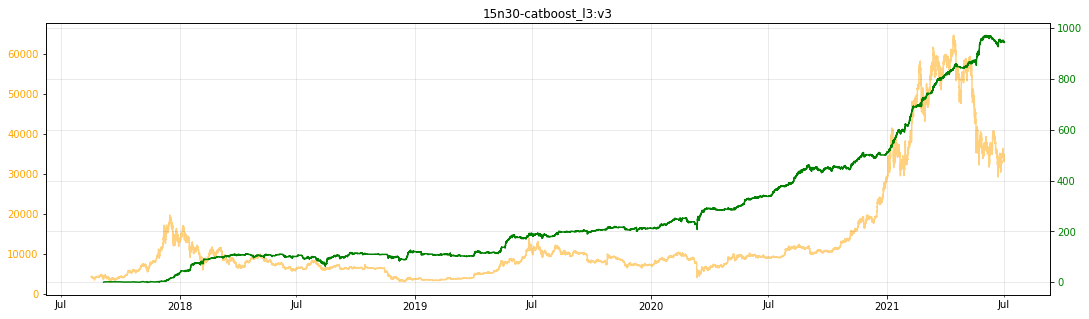

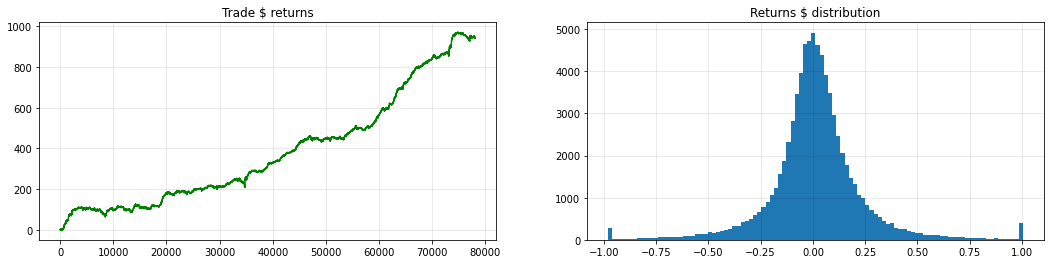

,Portfolio Summary
Trades,78067
Avg. Stake Amount,15.0
Number of Pairs,60
Min Balance,-0.85
Max Balance,971.4
Final Balance,943.73
-,-
Wins,40629
Loses,37438
Win Rate,52.04%


INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.backtest:|  'ml_val_15n30-catboost_l3__backtest-2021-09-03_19-32-05'
INFO:freqtrade.nbtools.backtest:|  WANDB LOG PRESET FINISHED  
INFO:freqtrade.nbtools.backtest:===============================


In [6]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -999
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1

            return dataframe
    """ End Strategy Code """

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)

# Backtesting: Strategy Optimization

INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_opt_15n30-catboost_l3 ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20210703-20210801
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20210703-20210801 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking exchange

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Preset Name: ml_opt_15n30-catboost_l3__backtest-2021-09-03_19-44-32


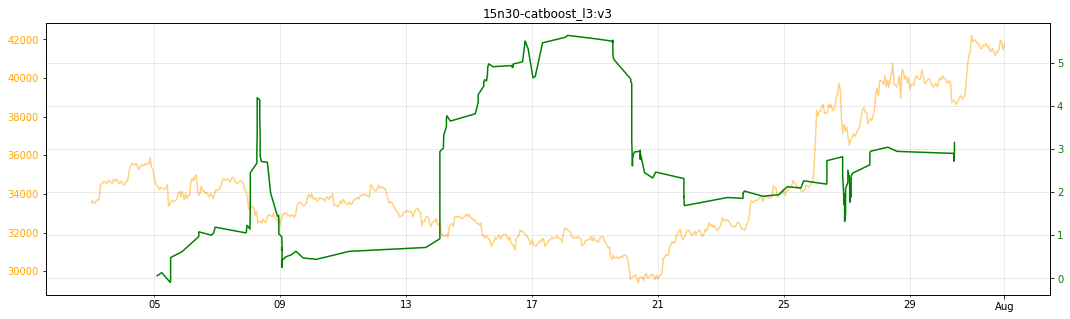

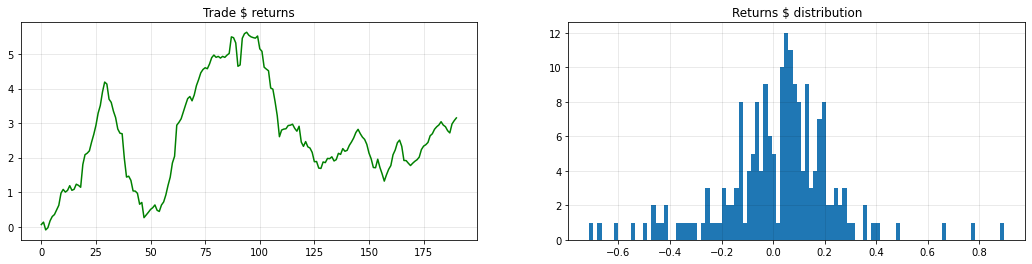

,Portfolio Summary
Trades,191
Avg. Stake Amount,15.0
Number of Pairs,45
Min Balance,-0.09
Max Balance,5.63
Final Balance,3.15
-,-
Wins,111
Loses,80
Win Rate,58.12%


In [18]:
"""
Phase where you can trial and error, plug and play model with any strategy, until get the best results.
In this phase, feel free to combine the trained model with a variety of technical indicators or ensemble with another model.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import freqtrade.vendor.qtpylib.indicators as qtpylib
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    import pandas_ta as pta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -0.99
        startup_candle_count: int = 500
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe["ema_volume"] = ta.EMA(dataframe["volume"], timeperiod=50)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.47,
                # TA filter
                # dataframe["close"] > dataframe["ema"],
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """


stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)

# Backtesting: Final Phase

INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Overwriting pairs (from 0 to 61 pairs)
INFO:freqtrade.nbtools.preset.base_preset:Setting config for ml_test_15n30-catboost_l3 ...
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
INFO:freqtrade.nbtools.preset.base_preset:Setting arg `timerange` to 20210802-20210901
INFO:freqtrade.loggers:Verbosity set to 0
INFO:freqtrade.configuration.configuration:Using max_open_trades: 6 ...
INFO:freqtrade.configuration.configuration:Parameter --timerange detected: 20210802-20210901 ...
INFO:freqtrade.configuration.configuration:Using user-data directory: c:\CS\Python\crypto-collection\freqtrade\superft\user_data ...
INFO:freqtrade.configuration.configuration:Using data directory: c:\CS\Python\crypto-collection\freqtrade\mount\data\binance ...
INFO:freqtrade.configuration.check_exchange:Checking exchang

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
C:\Users\User\AppData\Local\Temp/ipykernel_4072/3174916741.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Preset Name: ml_test_15n30-catboost_l3__backtest-2021-09-03_19-44-52


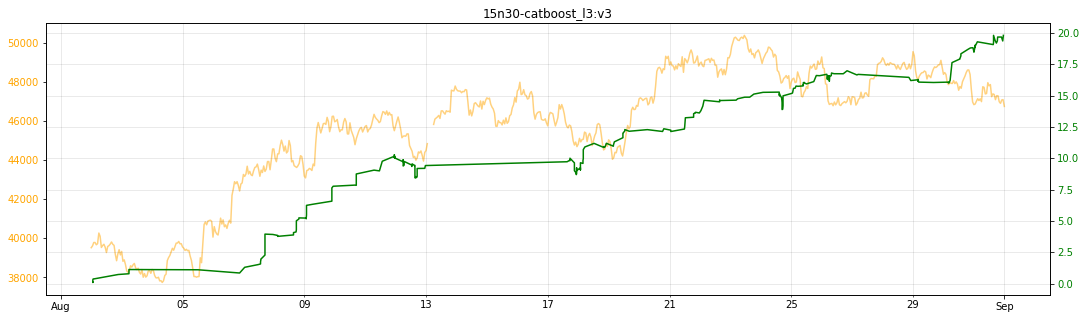

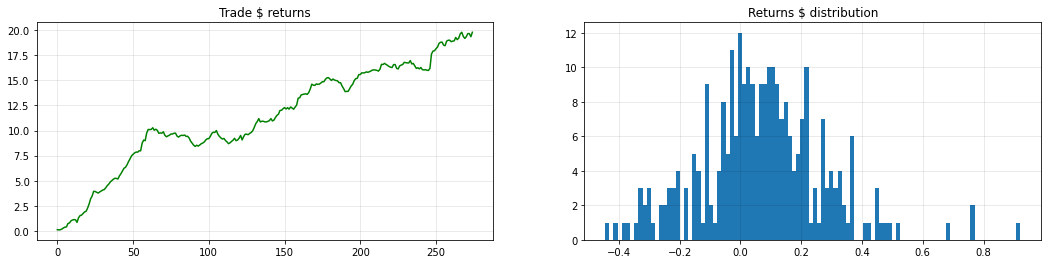

,Portfolio Summary
Trades,275
Avg. Stake Amount,15.0
Number of Pairs,47
Min Balance,0.09
Max Balance,19.81
Final Balance,19.8
-,-
Wins,182
Loses,93
Win Rate,66.18%


INFO:freqtrade.nbtools.backtest:===============================
INFO:freqtrade.nbtools.backtest:|  'ml_test_15n30-catboost_l3__backtest-2021-09-03_19-44-52'
INFO:freqtrade.nbtools.backtest:|  WANDB LOG PRESET FINISHED  
INFO:freqtrade.nbtools.backtest:===============================


In [19]:
"""
This is a phase where you believe your strategy is now optimized along with your model.
This is not trial and error phase, and you can only run this phase ONCE every "good" optimized strategy to avoid biased results.
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT, name=fullname)